# Convert color images to grayscale

## Problem

You need to convert color images to grayscale for analysis, preprocessing, or model inputs that require single-channel images.

Different conversion methods produce different results—you need to choose the right approach for your use case.

## Solution

**What's in this recipe:**

- Simple conversion with PIL
- Perceptually accurate grayscale (weighted RGB channels)
- Custom UDF for advanced conversion

You convert RGB images to grayscale in your table using either Pixeltable's built-in `.convert()` method for standard conversion, or a custom UDF (relies on NumPy and PIL/Pillow) for gamma-corrected conversion when scientific accuracy matters.

You can iterate on transformations before adding them to your table. Use `.select()` with `.collect()` to preview results on sample images—nothing is stored in your table. If you want to collect only the first few rows, use `.head(n)` instead of `.collect()`. Once you're satisfied, use `.add_computed_column()` to apply the conversion to all images in your table.

For more on this workflow, see [Get fast feedback on transformations](https://docs.pixeltable.com/howto/cookbooks/core/dev-iterative-workflow).

**Conversion methods:**

| Method | Speed | Accuracy | When to use |
|--------|-------|----------|-------------|
| **Simple (PIL `.convert('L')`)** | Fast | Good | Model preprocessing, general analysis |
| **Gamma-corrected (custom UDF)** | Slow | Best | Scientific imaging, professional photography |

The simple method uses PIL's built-in conversion. The gamma-corrected method requires a custom UDF (not built into PIL) that applies perceptual weighting in linear color space.

*For technical details on gamma correction and grayscale conversion, see [Wikipedia: Grayscale](https://en.wikipedia.org/wiki/Grayscale).*

### Setup

In [1]:
%pip install -qU pixeltable numpy

In [2]:
import pixeltable as pxt
import numpy as np
from PIL import Image

### Load images

In [3]:
# Create a fresh directory (drop existing if present)
pxt.drop_dir('image_demo', force=True)
pxt.create_dir('image_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/pjlb/.pixeltable/pgdata
Created directory 'image_demo'.


In [4]:
t = pxt.create_table('image_demo.gray', {'image': pxt.Image})

Created table 'gray'.


In [5]:
t.insert([
    {'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000036.jpg'},
    {'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000090.jpg'},
    {'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000106.jpg'},
])

Inserting rows into `gray`: 0 rows [00:00, ? rows/s]

Inserting rows into `gray`: 3 rows [00:00, 617.66 rows/s]


Inserted 3 rows with 0 errors.


3 rows inserted, 6 values computed.

image
""
""
""

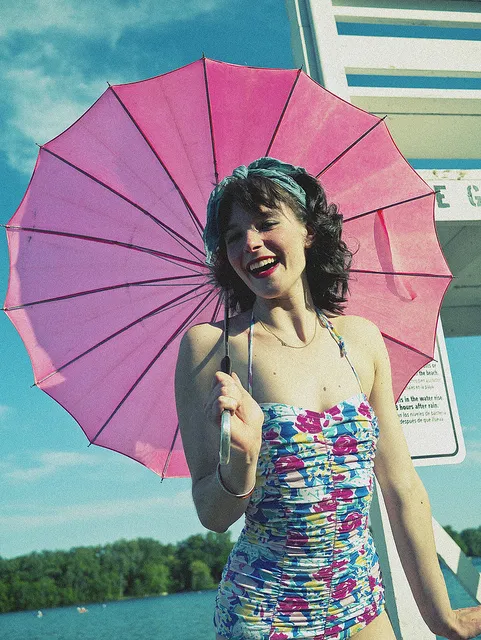
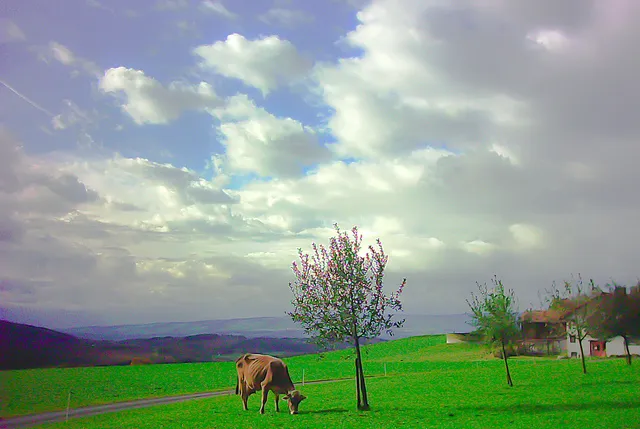
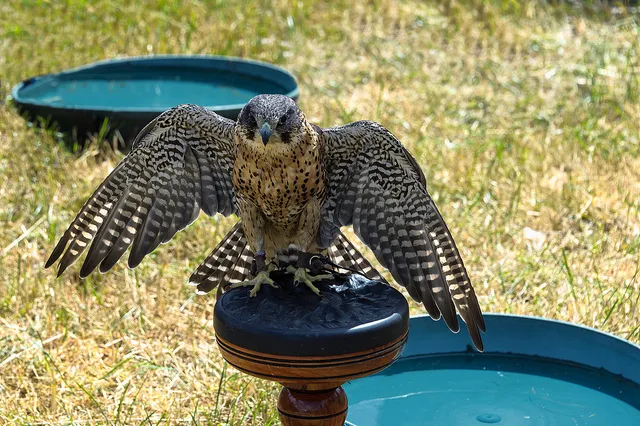

In [6]:
# View loaded images
t.collect()

### Iterate: convert with linear approximation for a few images first

image,convert
,

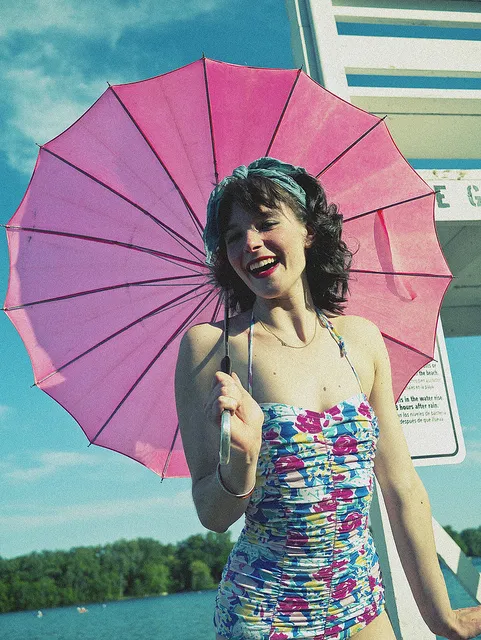
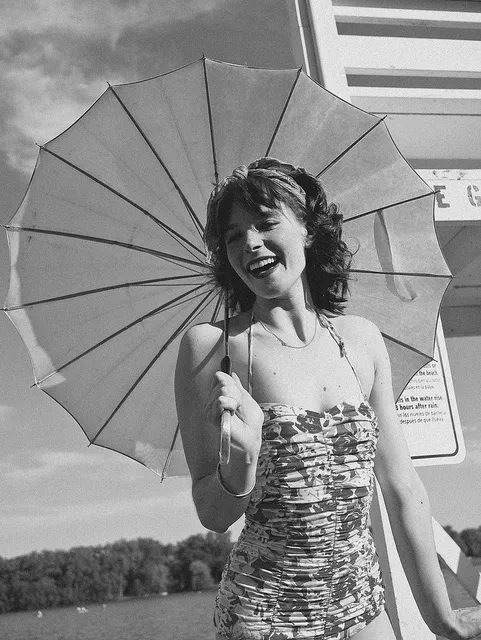

In [7]:
# Query: Preview the conversion
t.select(t.image, t.image.convert('L')).head(1)

### Add: convert with linear approximation for all images in your table

In [8]:
# Commit: Save as computed column (built-in PIL conversion - fast and good for most use cases)
t.add_computed_column(grayscale=t.image.convert('L'))

Added 3 column values with 0 errors.


3 rows updated, 3 values computed.

image,grayscale
,
,
,

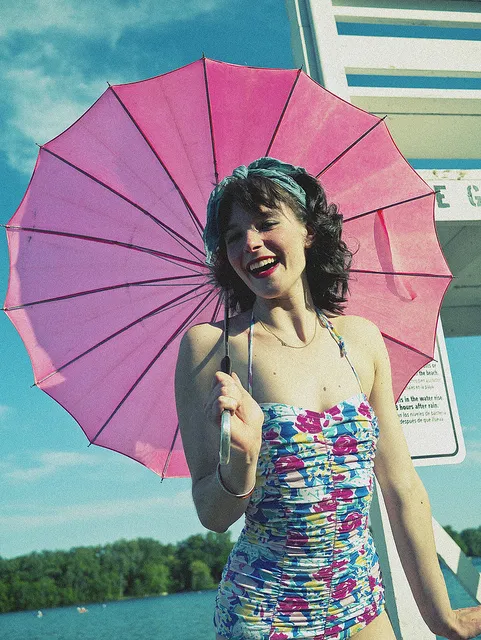
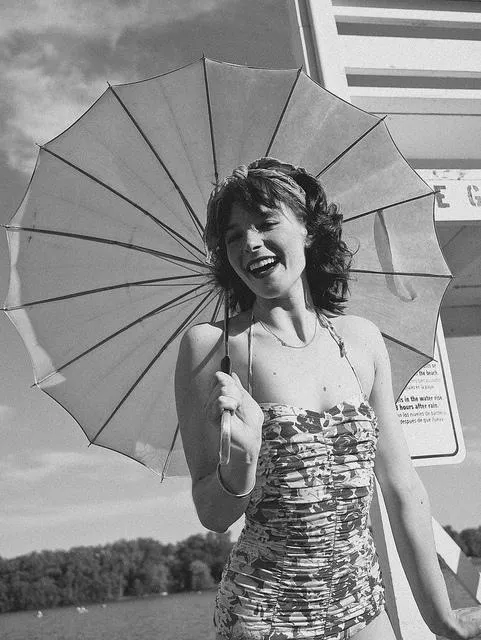
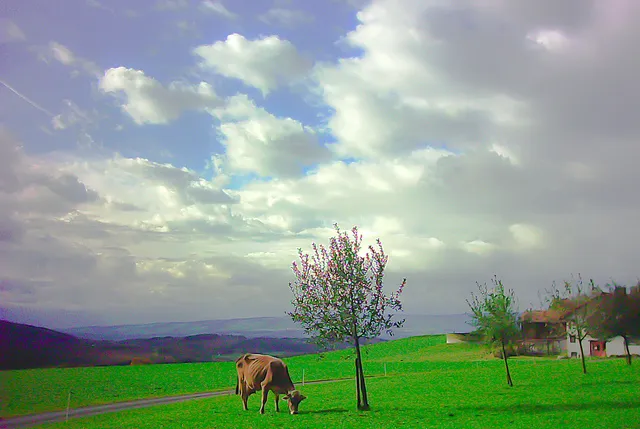
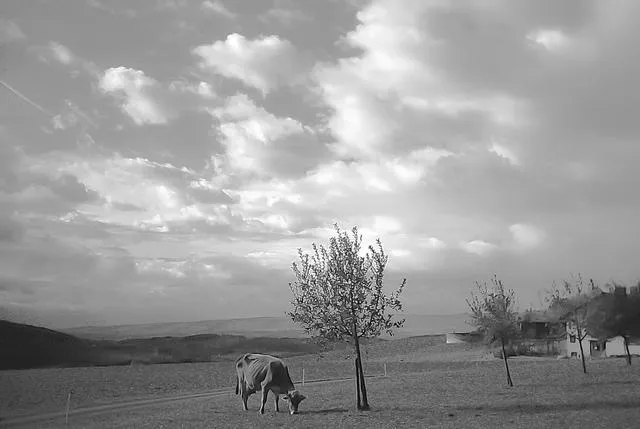
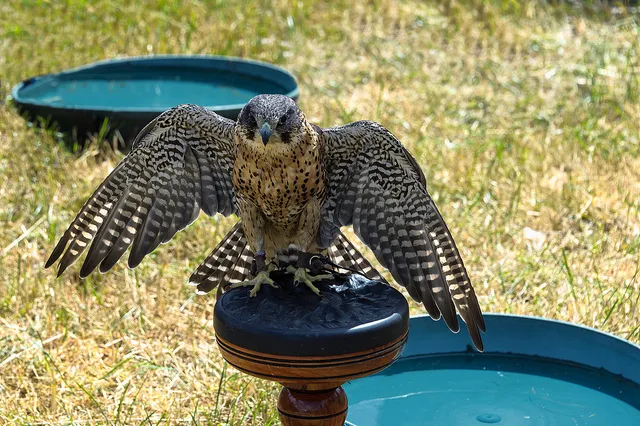
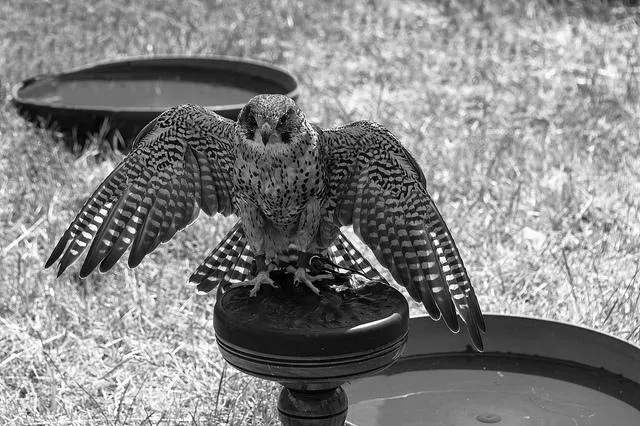

In [9]:
# View images with grayscale column
t.collect()

### Iterate: convert with gamma decompression for a few images first

In [10]:
@pxt.udf
def rgb_to_gray_accurate(img: Image.Image) -> Image.Image:
    """Convert RGB to grayscale with full gamma correction.

    Most accurate but slower. Gamma-decompresses, applies perceptual weights
    in linear space, then re-compresses for display.
    """
    rgb = np.array(img).astype(np.float32) / 255.0

    # Gamma decompress: make pixel values perceptually linear
    rgb_lin = ((rgb + 0.055) / 1.055) ** 2.4
    rgb_lin = np.where(rgb <= 0.04045, rgb / 12.92, rgb_lin)

    # Apply perceptual weights in linear space
    gray_lin = (
        0.2126 * rgb_lin[:, :, 0] +
        0.7152 * rgb_lin[:, :, 1] +
        0.0722 * rgb_lin[:, :, 2]
    )

    # Gamma compress: make values display-ready
    gray = 1.055 * gray_lin ** (1 / 2.4) - 0.055
    gray = np.where(gray_lin <= 0.0031308, 12.92 * gray_lin, gray)

    gray = (gray * 255).astype(np.uint8)
    return Image.fromarray(gray)

image,grayscale,rgb_to_gray_accurate
,,

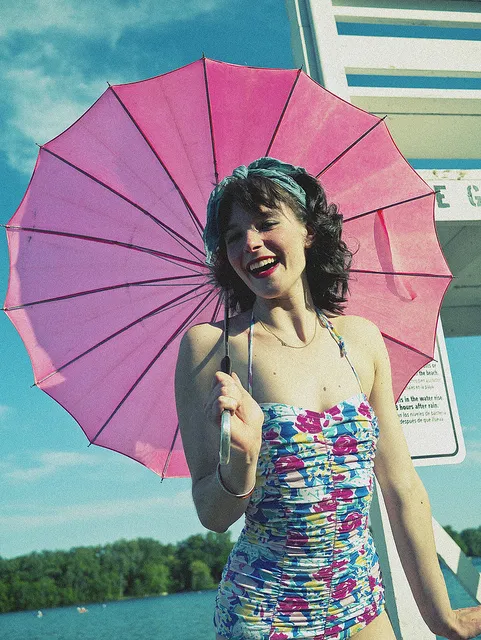
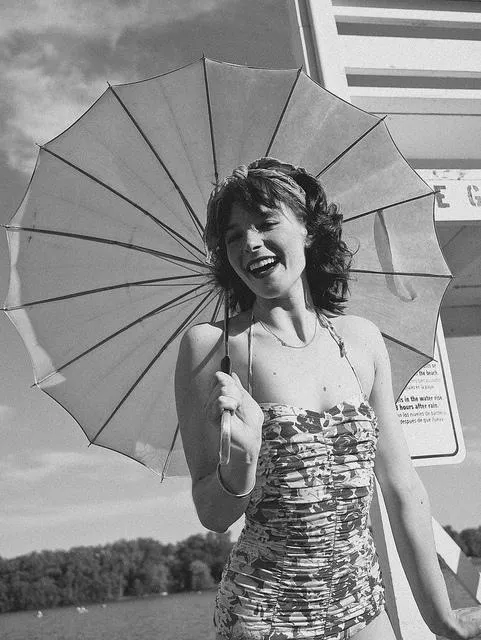
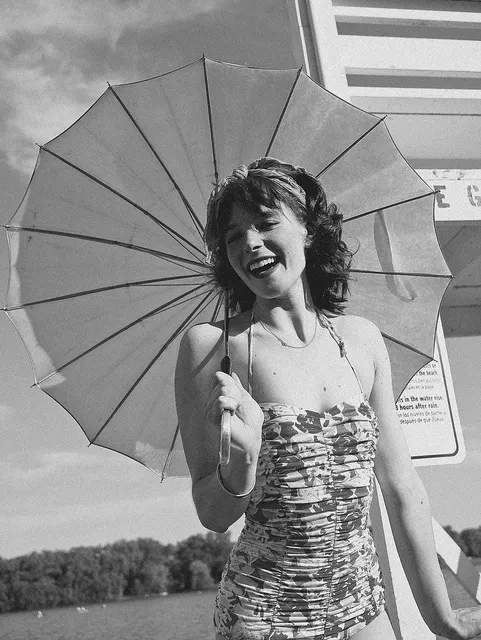

In [11]:
# Compare both methods on first image
t.select(
    t.image,
    t.grayscale,
    rgb_to_gray_accurate(t.image)
).head(1)

### Add: convert with gamma decompression for all images in your table

In [12]:
t.add_computed_column(accurate=rgb_to_gray_accurate(t.image))

Added 3 column values with 0 errors.


3 rows updated, 3 values computed.

image,grayscale,accurate
,,
,,
,,

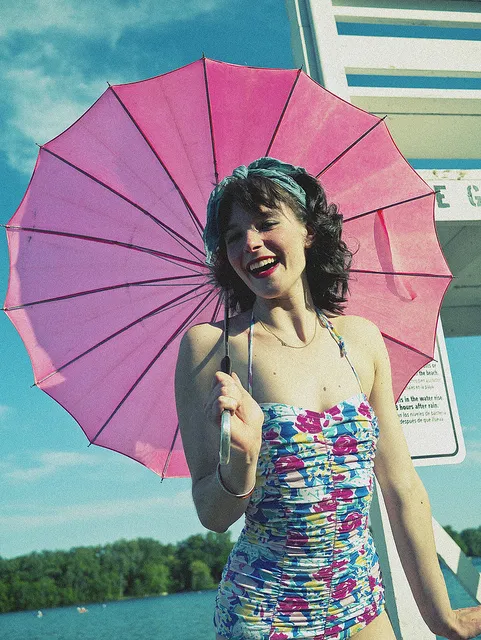
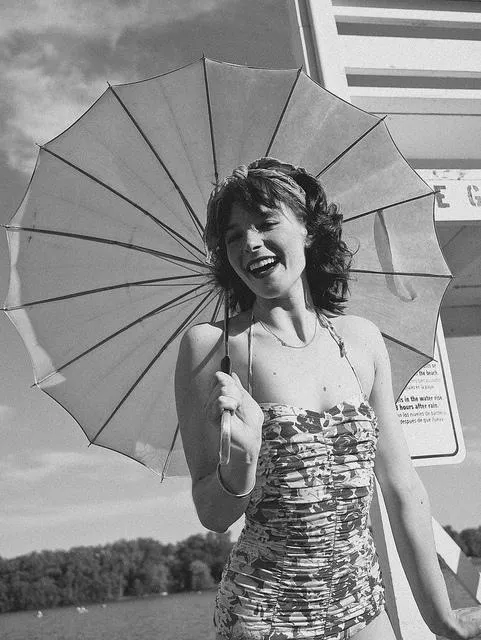
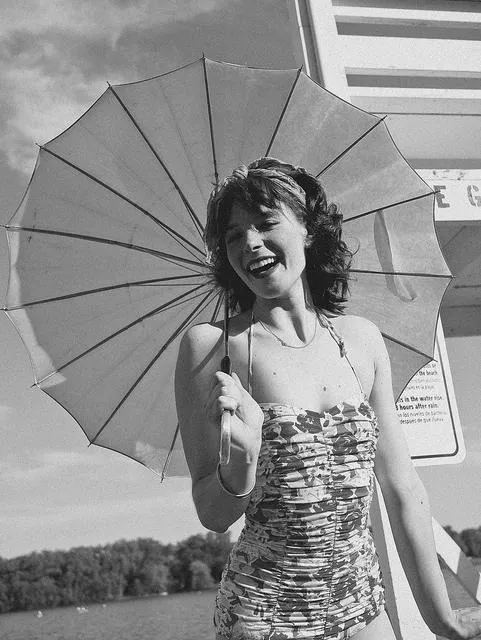
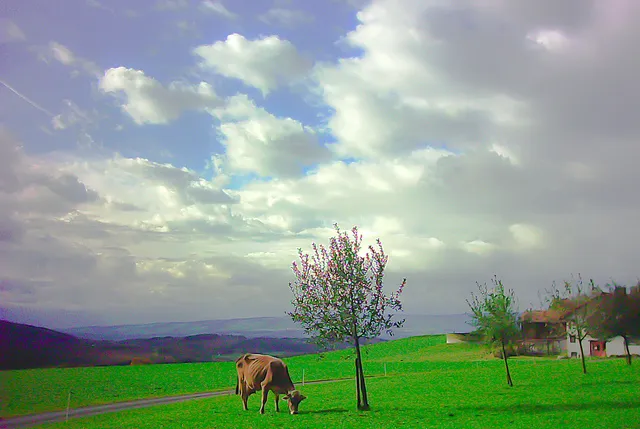
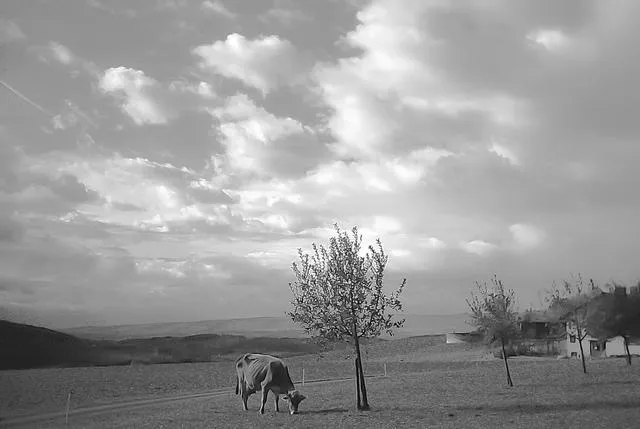
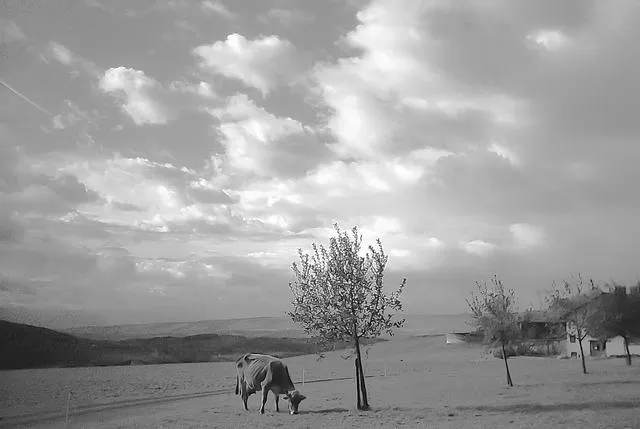
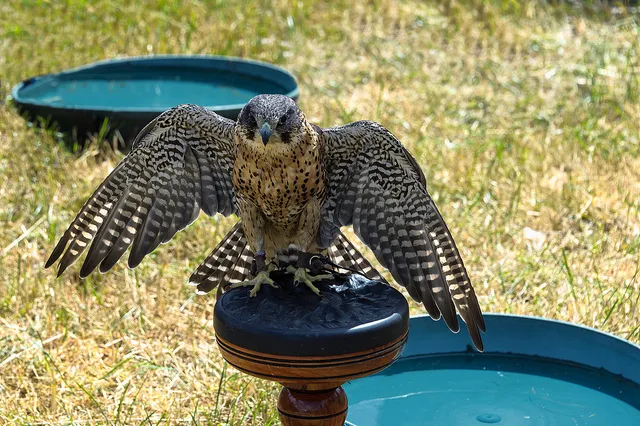
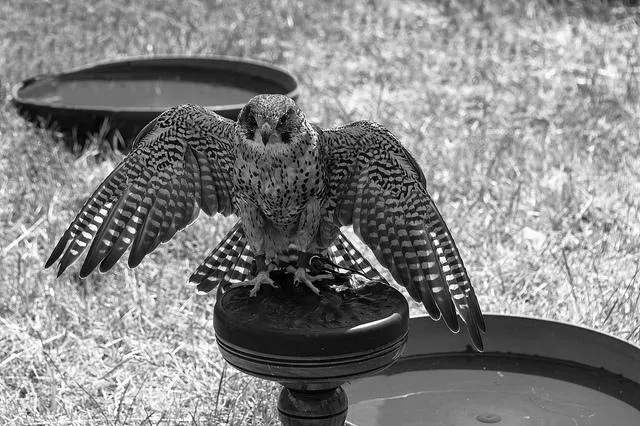
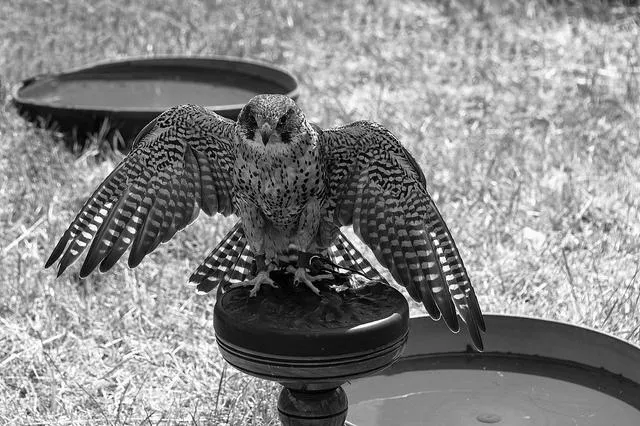

In [13]:
# View all results
t.collect()

## Explanation

**Two approaches:**

1. **Simple (`.convert('L')`):** PIL's built-in. Fast, good for most use cases (model preprocessing, general analysis).

1. **Gamma-corrected (custom UDF):** Not built into PIL. Requires a custom UDF that:

   - Gamma-decompresses to linear space
   - Applies perceptual weights: 0.2126 × R + 0.7152 × G + 0.0722 × B
   - Gamma-compresses back for display
   - Slower but most perceptually accurate
   - Use for scientific imaging, professional photography

**Why gamma matters:** Displays aren't linear—doubling a pixel value doesn't double perceived brightness. Gamma correction accounts for this. For best results, convert to linear space before weighting, then convert back.

*The gamma-corrected method is based on [Brandon Rohrer's explanation](https://brandonrohrer.com/convert_rgb_to_grayscale.html) of perceptually accurate RGB to grayscale conversion.*

**The Pixeltable workflow:**

In traditional databases, `.select()` just picks which columns to view. In Pixeltable, `.select()` also lets you compute new transformations on the fly—define new columns without storing them. This makes `.select()` perfect for testing transformations before you commit them.

When you use `.select()`, you're creating a query that doesn't execute until you call `.collect()`. You must use `.collect()` to execute the query and return results—nothing is stored in your table. If you want to collect only the first few rows, use `.head(n)` instead of `.collect()` to test on a subset before processing your full dataset. Once satisfied, use `.add_computed_column()` with the same expression to persist results permanently.

For more on this workflow, see [Get fast feedback on transformations](https://docs.pixeltable.com/howto/cookbooks/core/dev-iterative-workflow).

## See also

- [Transform images with PIL operations](https://docs.pixeltable.com/howto/cookbooks/images/img-pil-transforms)
- [Test transformations with fast feedback loops](https://docs.pixeltable.com/howto/cookbooks/core/dev-iterative-workflow)